# **DEPENDENCIES**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

In [2]:
from google.colab import drive; drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATASET**

In [3]:
def create_dataset(faces_dataset_path):
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []
    test_images = []
    test_labels = []

    class_labels = os.listdir(faces_dataset_path)
    num_classes = len(class_labels)

    for class_idx, folder in enumerate(tqdm(class_labels)):
        folder_path = os.path.join(faces_dataset_path, folder)
        images = os.listdir(folder_path)
        np.random.shuffle(images)
        num_images = len(images)

        for i, file in enumerate(images):
            img = cv2.imread(os.path.join(folder_path, file))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if i < 0.7 * num_images:
                train_images.append(img)
                train_labels.append(class_idx)
            elif i < 0.85 * num_images:
                val_images.append(img)
                val_labels.append(class_idx)
            else:
                test_images.append(img)
                test_labels.append(class_idx)

    return (
        np.array(train_images), np.array(train_labels),
        np.array(val_images), np.array(val_labels),
        np.array(test_images), np.array(test_labels)
    )

### **Human Dataset**   
Images of humans in frame

In [4]:
human_dataset_path = "/content/drive/MyDrive/data_assn2_cv/human detection dataset"
Xtrh, Ytrh, Xvah, Yvah, Xteh, Yteh = create_dataset(human_dataset_path)

100%|██████████| 2/2 [00:26<00:00, 13.45s/it]


### **Faces Dataset**
Face images of 9 celebrities

In [12]:
face_dataset_path = "/content/drive/MyDrive/data_assn2_cv/actors/faces"
Xtrf, Ytrf, Xvaf, Yvaf, Xtef, Ytef = create_dataset(face_dataset_path)

100%|██████████| 9/9 [02:32<00:00, 16.98s/it]


# **HOG**  
### Histogram of Oriented Gradients (HOG) Computation

The `compute_hog` function takes an input grayscale image, `cell_size`, `block_size`, and `num_bins`. It calculates HOG feature vectors by analyzing the local gradient information within the image. Default is num_bin=255

### Formula

For each cell in the image:

- Calculate gradients in the x and y directions using Sobel operators.
- Calculate the magnitude and direction of gradients.
- Define the number of cells in the x and y directions.
- Create a histogram for each cell, quantizing gradient directions into bins.
- Combine histograms into HOG feature vectors for the entire image.

### Output

The output is an array of HOG feature vectors representing the image, with each vector encoding local gradient information for a specific region of the image.

In [5]:
def convolution2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    output = np.zeros((output_height, output_width))
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(
                image[i : i + kernel_height, j : j + kernel_width] * kernel
            )
    return output


def compute_oriented_gradients(image_array):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    num_images = len(image_array)
    gradient_magnitudes = np.zeros(
        (num_images, image_array.shape[1] - 2, image_array.shape[2] - 2)
    )
    gradient_orientations = np.zeros(
        (num_images, image_array.shape[1] - 2, image_array.shape[2] - 2)
    )

    for i, image in tqdm(enumerate(image_array), total=num_images):
        gradient_x = convolution2d(image, sobel_x)
        gradient_y = convolution2d(image, sobel_y)
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        gradient_orientation = np.arctan2(gradient_y, gradient_x)

        gradient_magnitudes[i] = gradient_magnitude
        gradient_orientations[i] = gradient_orientation

    return np.array(gradient_magnitudes), np.array(gradient_orientations)

## Compute HOG
### Explanation

1. **Compute Gradient Magnitudes and Orientations:**
   - Calculate gradient magnitudes and orientations for the given image using the `compute_oriented_gradients` function.

2. **Divide the Image into Cells:**
   - Divide the image into smaller cells, as specified by the `cell_size`.

3. **Calculate Histograms for Each Cell:**
   - For each cell, calculate a histogram of gradient orientations. This histogram represents the distribution of edge orientations in that cell.

4. **Group Cells into Blocks:**
   - Group cells into blocks as specified by the `block_size`. Blocks overlap to capture more information.

5. **Normalize Block Features:**
   - Normalize the block features to account for variations in lighting and contrast.

6. **Flatten and Collect Features:**
   - Flatten the block features and collect them for all cells in the image.


In [6]:
def compute_hog(image_array, cell_size=(16, 16), block_size=(4, 4), bins=3):
    gradient_magnitudes, gradient_orientations = compute_oriented_gradients(image_array)
    hog_features = []

    for gradient_magnitude, gradient_orientation in tqdm(zip(
        gradient_magnitudes, gradient_orientations)
    ):
        num_cells_x = gradient_magnitude.shape[1] // cell_size[1]
        num_cells_y = gradient_magnitude.shape[0] // cell_size[0]
        histograms = np.zeros((num_cells_y, num_cells_x, bins))
        block_features = np.zeros(
            (
                num_cells_y - block_size[0] + 1,
                num_cells_x - block_size[1] + 1,
                block_size[0],
                block_size[1],
                bins,
            )
        )

        for y in range(num_cells_y):
            for x in range(num_cells_x):
                cell_magnitude = gradient_magnitude[
                    y * cell_size[0] : (y + 1) * cell_size[0],
                    x * cell_size[1] : (x + 1) * cell_size[1],
                ]
                cell_orientation = gradient_orientation[
                    y * cell_size[0] : (y + 1) * cell_size[0],
                    x * cell_size[1] : (x + 1) * cell_size[1],
                ]
                histograms[y, x], _ = np.histogram(
                    cell_orientation,
                    bins=np.linspace(0, 2 * np.pi, bins + 1),
                    weights=cell_magnitude,
                )
        for y in range(num_cells_y - block_size[0] + 1):
            for x in range(num_cells_x - block_size[1] + 1):
                block = histograms[y : y + block_size[0], x : x + block_size[1]]
                block_features[y, x] = block
        block_features = block_features / np.sqrt(np.sum(block_features**2) + 1e-6)

        hog_features.append(block_features.flatten())
    return np.array(hog_features)

In [7]:
Xtrfh = compute_hog(Xtrh)
Xtefh = compute_hog(Xteh)
Xvafh = compute_hog(Xvah)

100%|██████████| 646/646 [01:59<00:00,  5.40it/s]
646it [00:03, 212.73it/s]
100%|██████████| 137/137 [00:24<00:00,  5.51it/s]
137it [00:00, 179.86it/s]
100%|██████████| 138/138 [00:25<00:00,  5.44it/s]
138it [00:00, 182.10it/s]


### Plot of Original vs OG images

In [8]:
def plot_hog(original_images):
    num_images = len(original_images)
    gradient_magnitudes, gradient_orientations = compute_oriented_gradients(original_images)
    hog_features = compute_hog(original_images)

    fig, axs = plt.subplots(4, num_images, figsize=(4 * num_images, 12))
    plt.tight_layout(pad=0.0)

    for i in range(num_images):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')

        axs[1, i].imshow(gradient_magnitudes[i], cmap='gray')
        axs[1, i].set_title('Gradient Magnitude')
        axs[1, i].axis('off')

        axs[2, i].imshow(gradient_orientations[i], cmap='hsv', vmin=-np.pi, vmax=np.pi)
        axs[2, i].set_title('Gradient Orientation')
        axs[2, i].axis('off')

        axs[3, i].plot(hog_features[i])
        axs[3, i].set_title('HOG')

    plt.show()

100%|██████████| 5/5 [00:00<00:00,  6.17it/s]
5it [00:00, 250.04it/s]


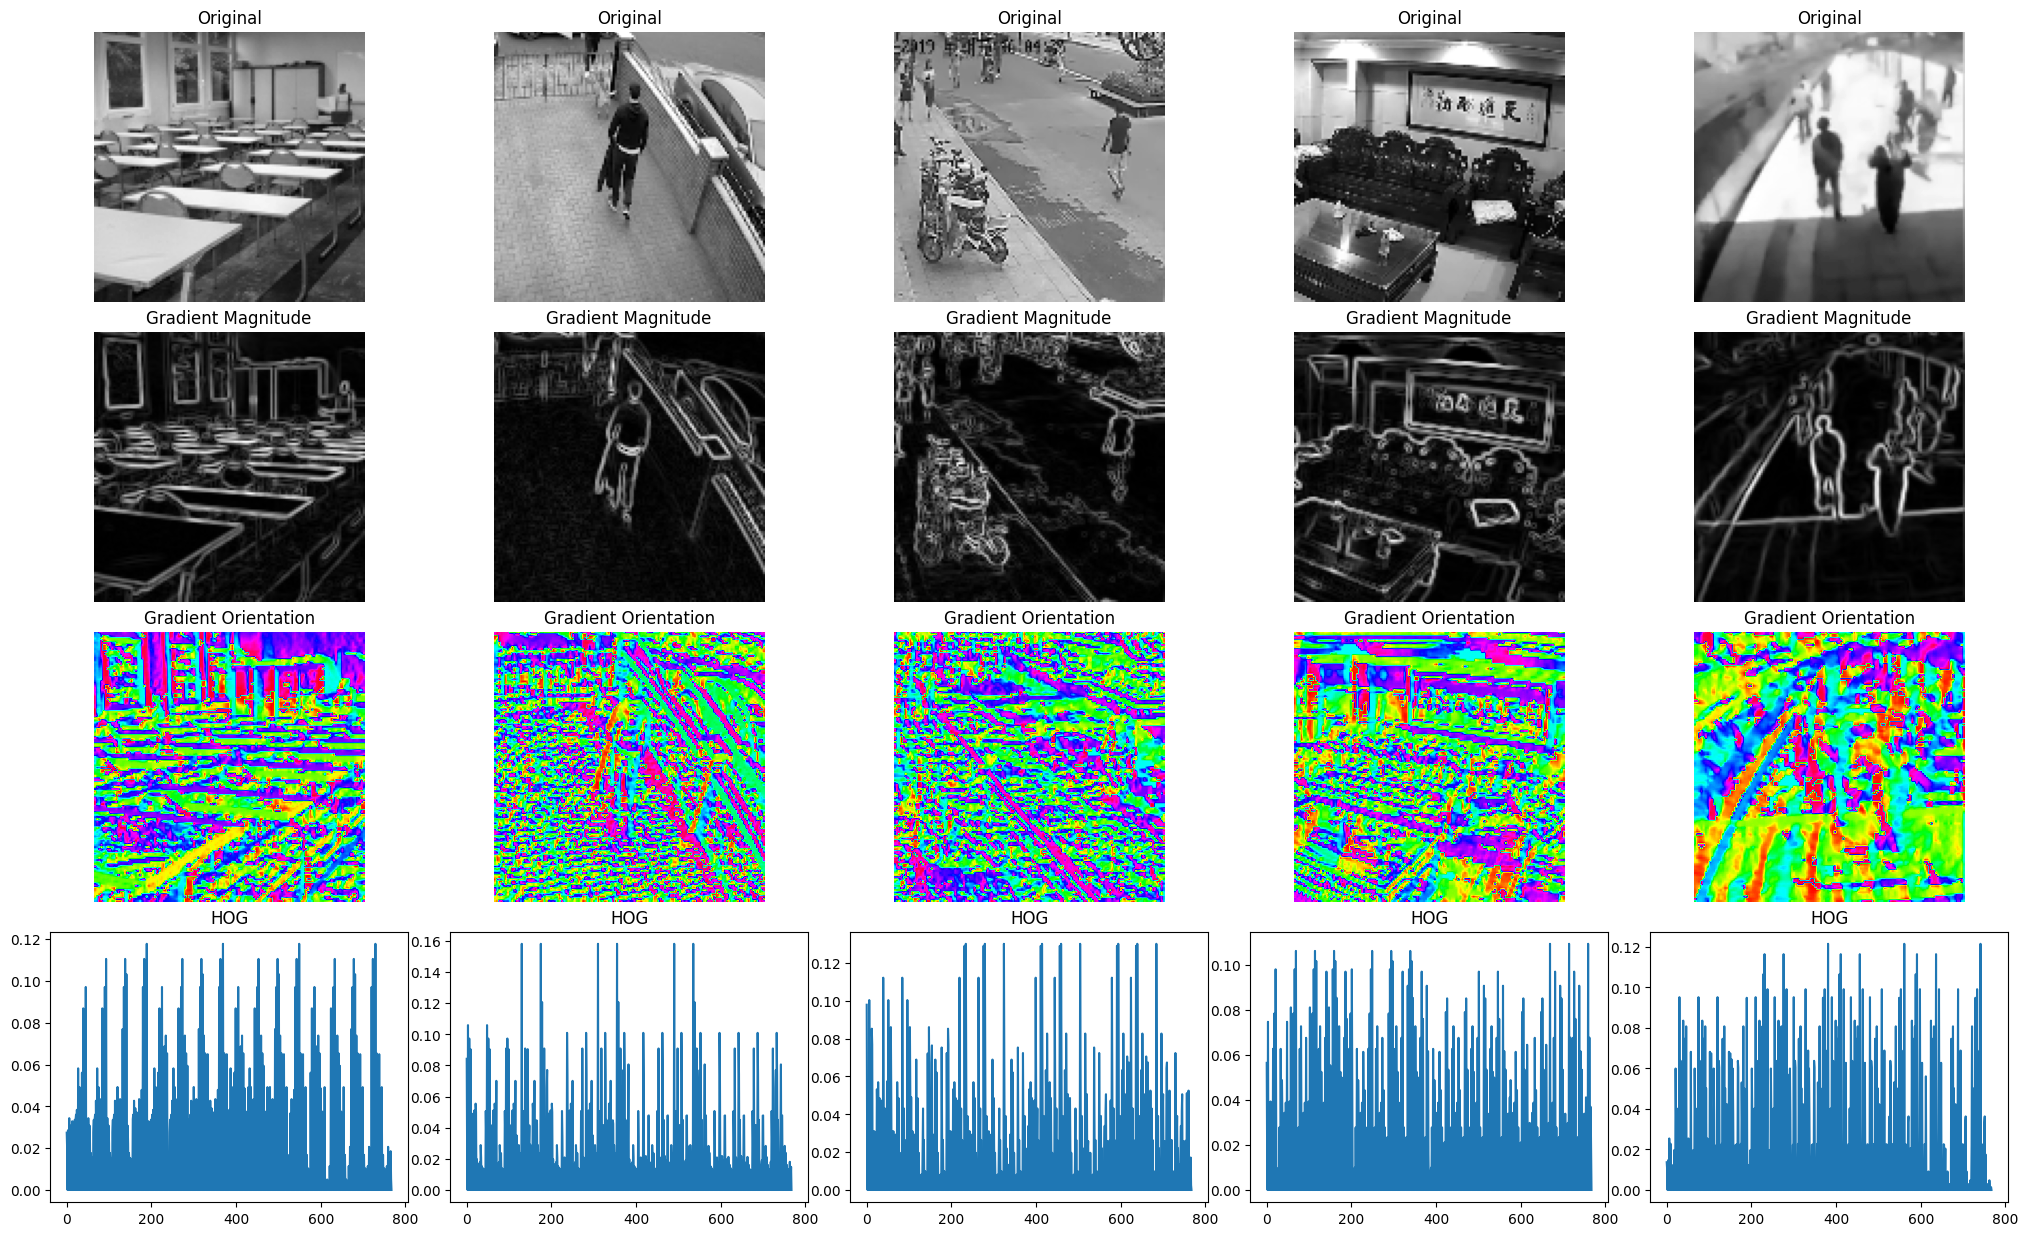

In [9]:
S = Xtrh[np.random.randint(0, Xtrh.shape[0], 5)]; plot_hog(S)

# **HUMAN Vs NON-HUMAN**

# **KNN**

In [16]:
class KNNClassifier():
    def __init__(self, K, metric='euclidean'):
        self.K = K
        self.metric = metric
        self.inv_mcm = None

    @staticmethod
    def mode(arr):
        unique, counts = np.unique(arr, return_counts=True)
        return unique[np.argmax(counts)]

    def euclidean_distance(self, x):
        return np.sqrt(np.sum((self.X - x) ** 2, axis=1))

    def manhattan_distance(self, x):
        return np.sum(np.abs(self.X - x), axis=1)

    def chebyshev_distance(self, x):
        return np.max(np.abs(self.X - x), axis=1)

    def mahalanobis_distance(self, x):
        if self.inv_mcm is None:
            raise ValueError("Covariance matrix is not available.")
        diff = self.X - x
        distances = np.sqrt(np.sum(np.dot(diff, self.inv_mcm) * diff, axis=1))
        return distances

    def minkowski_distance(self, x, p=2):
        return np.power(np.sum(np.power(np.abs(self.X - x), p), axis=-1), 1/p)

    def cosine_distance(self, x):
        dot_product = np.dot(self.X, x)
        norm_x = np.linalg.norm(x)
        norm_data = np.linalg.norm(self.X, axis=1)
        cosine_sim = dot_product / (norm_x * norm_data)
        cosine_distance = 1 - cosine_sim
        return cosine_distance

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = X.shape

        if self.metric == 'mahalanobis':
            mah_covariance_matrix = np.cov(X, rowvar=False, bias=True)
            self.inv_mcm = np.linalg.pinv(mah_covariance_matrix)

    def predict(self, X):
        self.X_test = X
        self.m_test, _ = X.shape
        Y_predict = np.zeros(self.m_test)

        for i in range(self.m_test):
            x = X[i]
            neighbors = self.find_neighbors(x)
            Y_predict[i] = self.mode(neighbors)

        return Y_predict

    def find_neighbors(self, x):
        if self.metric == 'mahalanobis':
            distances = self.mahalanobis_distance(x)
        elif self.metric == 'euclidean':
            distances = self.euclidean_distance(x)
        elif self.metric == 'manhattan':
            distances = self.manhattan_distance(x)
        elif self.metric == 'chebyshev':
            distances = self.chebyshev_distance(x)
        elif self.metric == 'minkowski':
            distances = self.minkowski_distance(x)
        elif self.metric == 'cosine':
            distances = self.cosine_distance(x)

        inds = distances.argsort()
        Y_sorted = self.Y[inds]
        return Y_sorted[:self.K]

    def score(self, X_test, Y_true):
        Y_pred = self.predict(X_test)
        accuracy = np.mean(Y_pred == Y_true)
        return accuracy

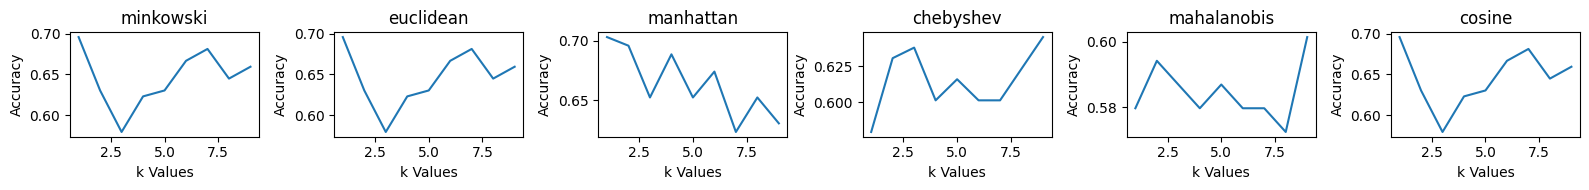

Best KNN model on validation data: K=1, metric-manhattan: Score (Val acc)=0.7028985507246377
Accuracy on train data: 0.9984520123839009
Accuracy on val data: 0.7028985507246377
Accuracy on test data: 0.5985401459854015


In [124]:
k_values = range(1, 10)
distance_metrics = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'cosine']
best_model = None
best_score = 0
fig, axes = plt.subplots(1, 6, figsize=(16, 2))
for j, distance_metric in enumerate(distance_metrics):
    accuracy_values = []
    for k in k_values:
        knn = KNNClassifier(k, metric=distance_metric)
        knn.fit(Xtrfh, Ytrh)
        accuracy = knn.score(Xvafh, Yvah)
        if accuracy > best_score:
            best_model = knn
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[j]
    ax.plot(k_values, accuracy_values)
    ax.set_xlabel('k Values')
    ax.set_ylabel('Accuracy')
    ax.set_title(distance_metric)
plt.tight_layout()
plt.show()
print(f"Best KNN model on validation data: K={best_model.K}, metric-{best_model.metric}: Score (Val acc)={best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrh)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvah)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Yteh)}")

Surprisingly, manhattan distance proves to be the most successful.

# **SVM**

In [9]:
from sklearn import svm

4it [01:23, 20.76s/it]


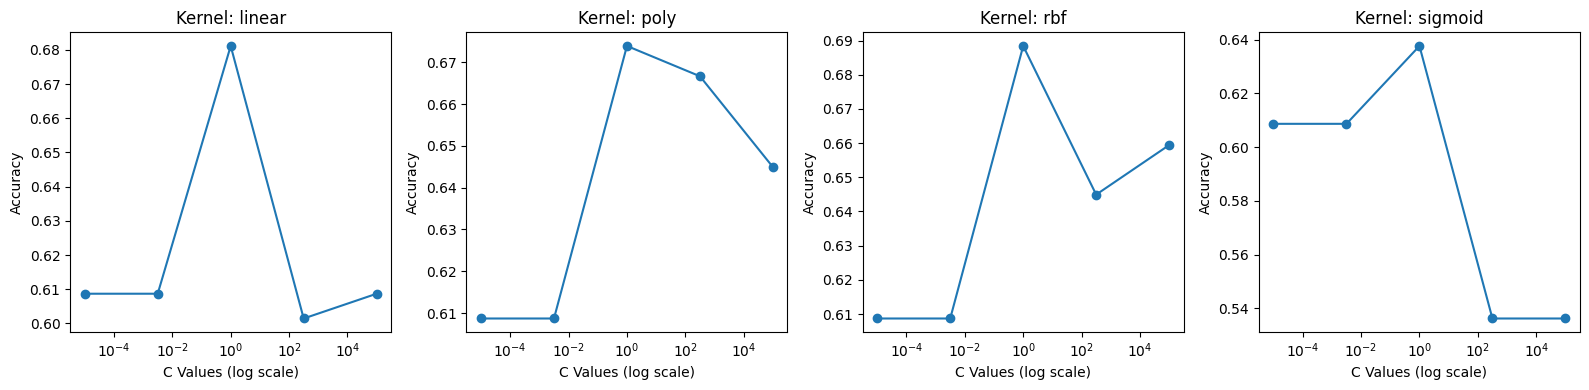

Best SVM model on validation data: C=1.0, kernel-rbf | Accuracy = 0.6884057971014492
Accuracy on train data: 0.7987616099071208
Accuracy on val data: 0.6884057971014492
Accuracy on test data: 0.6204379562043796


In [10]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = np.logspace(-5, 5, 5)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in tqdm(enumerate(kernels)):
    accuracy_values = []
    for C in C_values:
        svm_classifier = svm.SVC(kernel=kernel, C=C, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrh)
        accuracy = svm_classifier.score(Xvafh, Yvah)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(C_values, accuracy_values, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel('C Values (log scale)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: C={best_model.C}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrh)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvah)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Yteh)}")

SVM better fits the train and validation data.

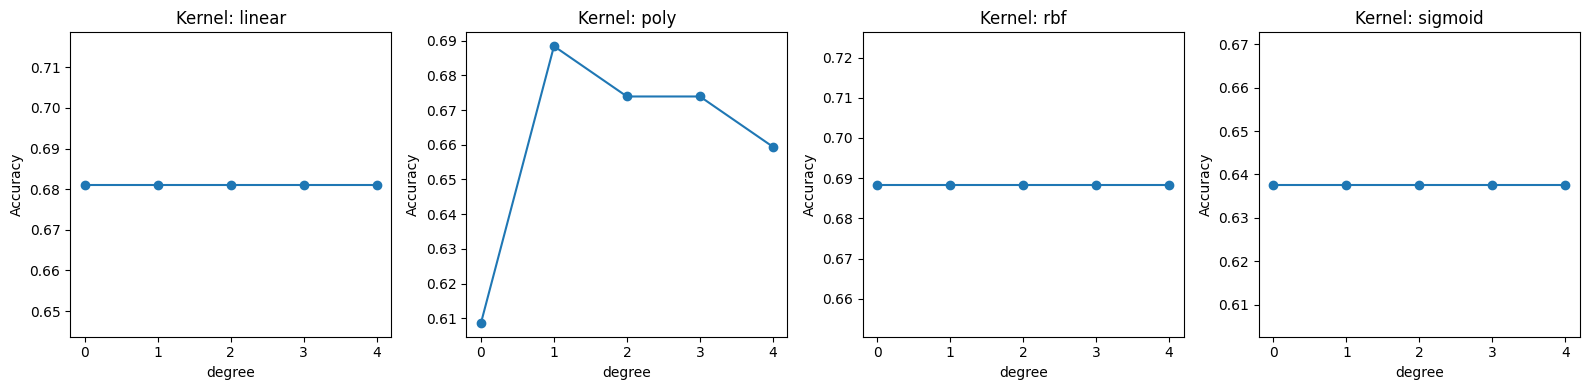

Best SVM model on validation data: d=1, kernel-poly | Accuracy = 0.6884057971014492
Accuracy on train data: 0.7198142414860681
Accuracy on val data: 0.6884057971014492
Accuracy on test data: 0.6423357664233577


In [11]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = np.arange(5)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for d in degrees:
        svm_classifier = svm.SVC(kernel=kernel, degree=d, decision_function_shape='ovr')
        svm_classifier.fit(Xtrfh, Ytrh)
        accuracy = svm_classifier.score(Xvafh, Yvah)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(degrees, accuracy_values, marker='o')
    ax.set_xlabel('degree')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: d={best_model.degree}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrfh, Ytrh)}")
print(f"Accuracy on val data: {best_model.score(Xvafh, Yvah)}")
print(f"Accuracy on test data: {best_model.score(Xtefh, Yteh)}")

3rd degree polynomial was best for SVM polynomial kernel

SVMs exceed KNN even on test data even though the parameter space was restricted to save compute time.

# **HUMAN CLASSIFICATION**

In [13]:
Xtrff = compute_hog(Xtrf)
Xteff = compute_hog(Xtef)
Xvaff = compute_hog(Xvaf)

100%|██████████| 323/323 [01:02<00:00,  5.14it/s]
323it [00:01, 171.70it/s]
100%|██████████| 65/65 [00:11<00:00,  5.48it/s]
65it [00:00, 177.84it/s]
100%|██████████| 69/69 [00:12<00:00,  5.31it/s]
69it [00:00, 183.91it/s]


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]
5it [00:00, 160.10it/s]


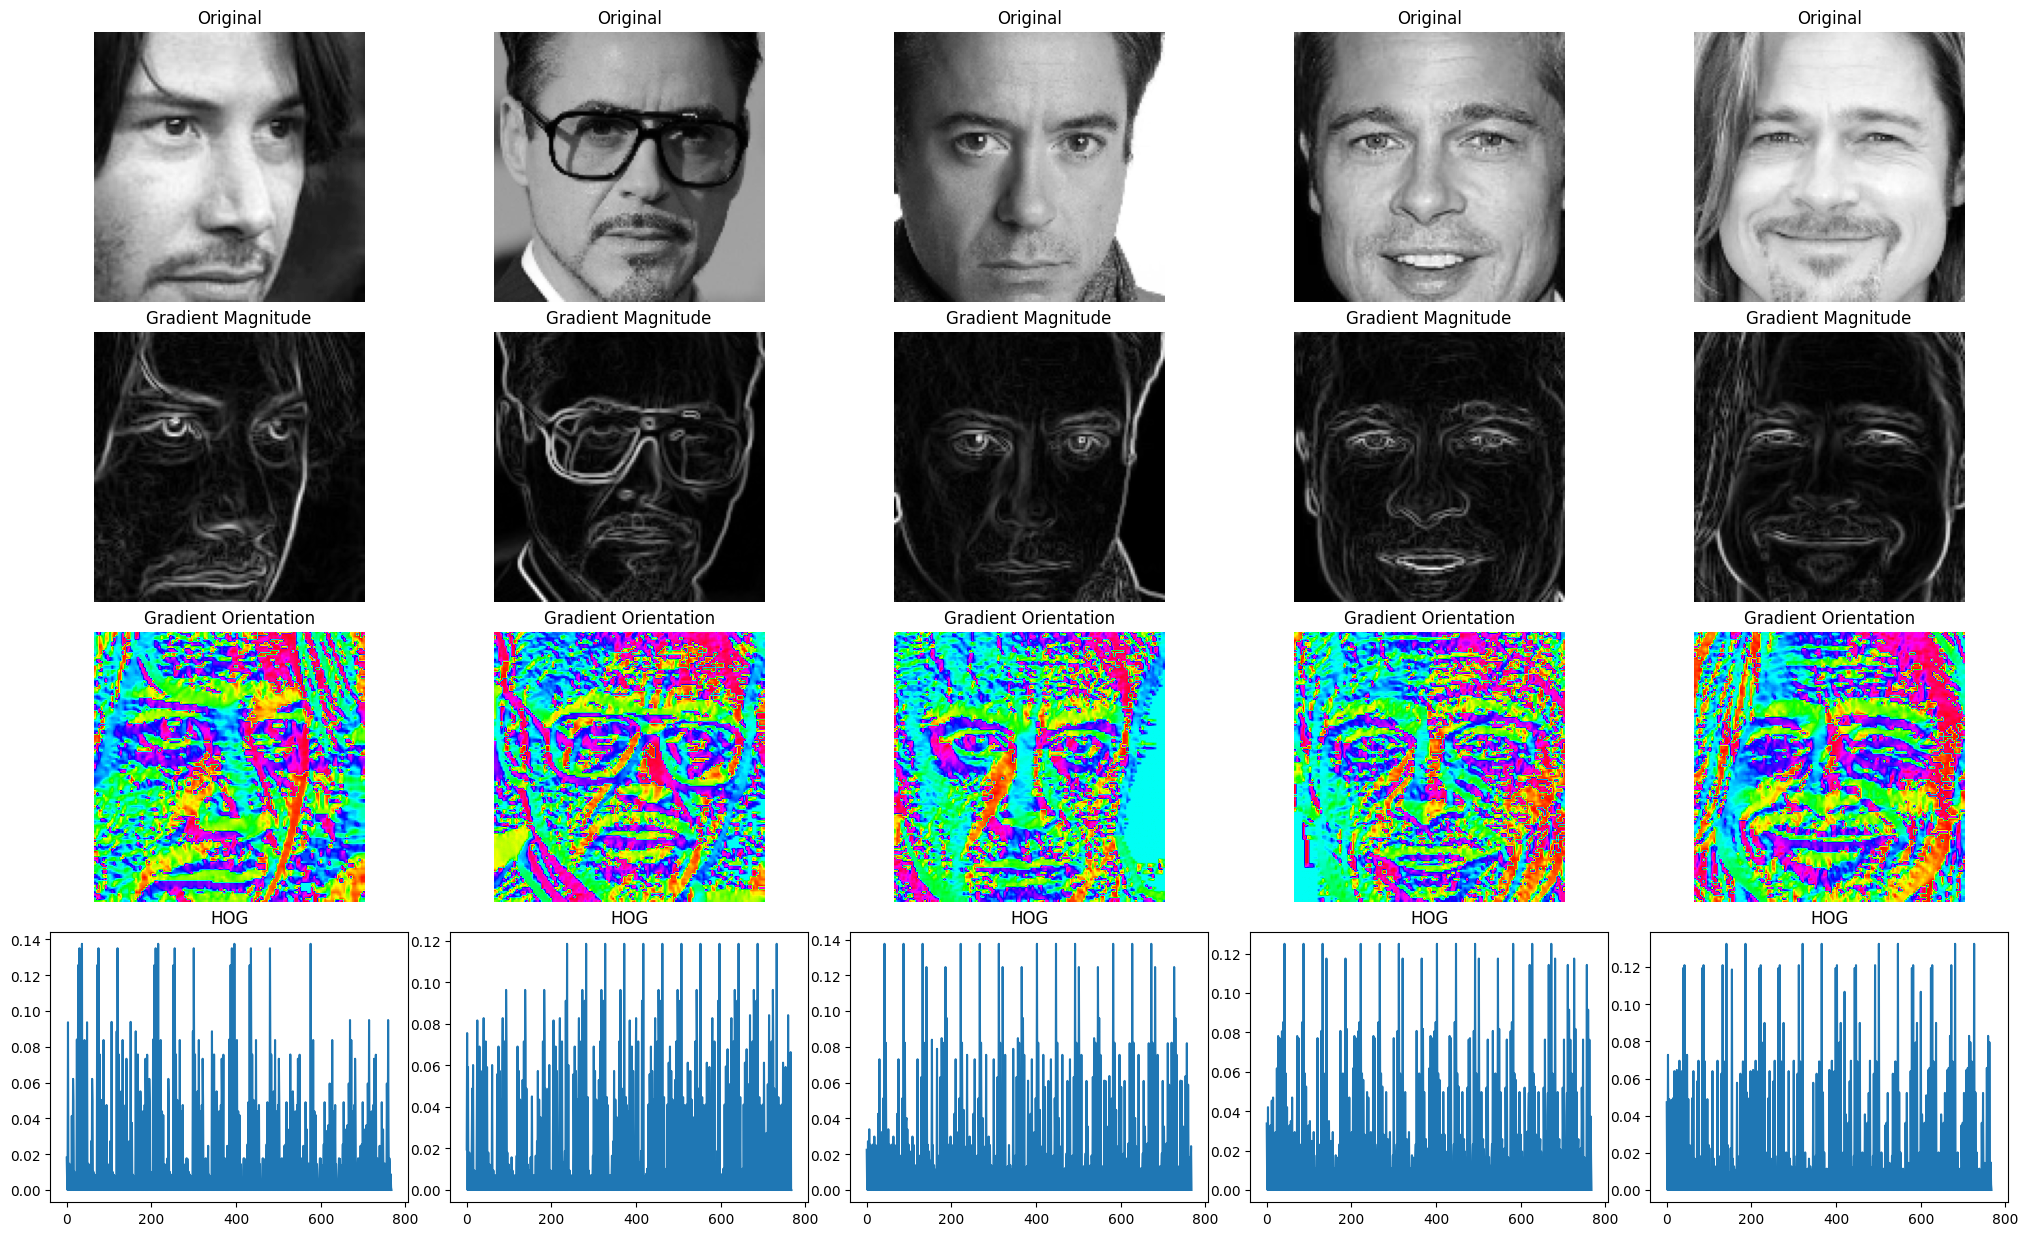

In [14]:
S = Xtrf[np.random.randint(0, Xtrf.shape[0], 5)]; plot_hog(S)

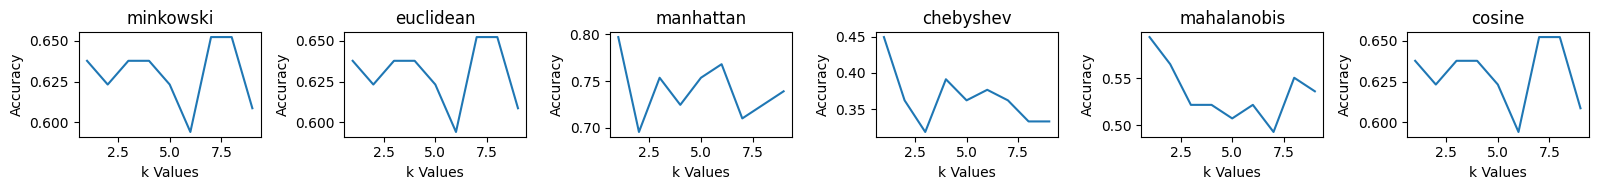

Best KNN model on validation data: K=1, metric-manhattan: Score (Val acc)=0.7971014492753623
Accuracy on train data: 1.0
Accuracy on val data: 0.7971014492753623
Accuracy on test data: 0.6615384615384615


In [18]:
k_values = range(1, 10)
distance_metrics = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'cosine']
best_model = None
best_score = 0
fig, axes = plt.subplots(1, 6, figsize=(16, 2))
for j, distance_metric in enumerate(distance_metrics):
    accuracy_values = []
    for k in k_values:
        knn = KNNClassifier(k, metric=distance_metric)
        knn.fit(Xtrff, Ytrf)
        accuracy = knn.score(Xvaff, Yvaf)
        if accuracy > best_score:
            best_model = knn
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[j]
    ax.plot(k_values, accuracy_values)
    ax.set_xlabel('k Values')
    ax.set_ylabel('Accuracy')
    ax.set_title(distance_metric)
plt.tight_layout()
plt.show()
print(f"Best KNN model on validation data: K={best_model.K}, metric-{best_model.metric}: Score (Val acc)={best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrff, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvaff, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xteff, Ytef)}")

4it [00:00,  7.02it/s]


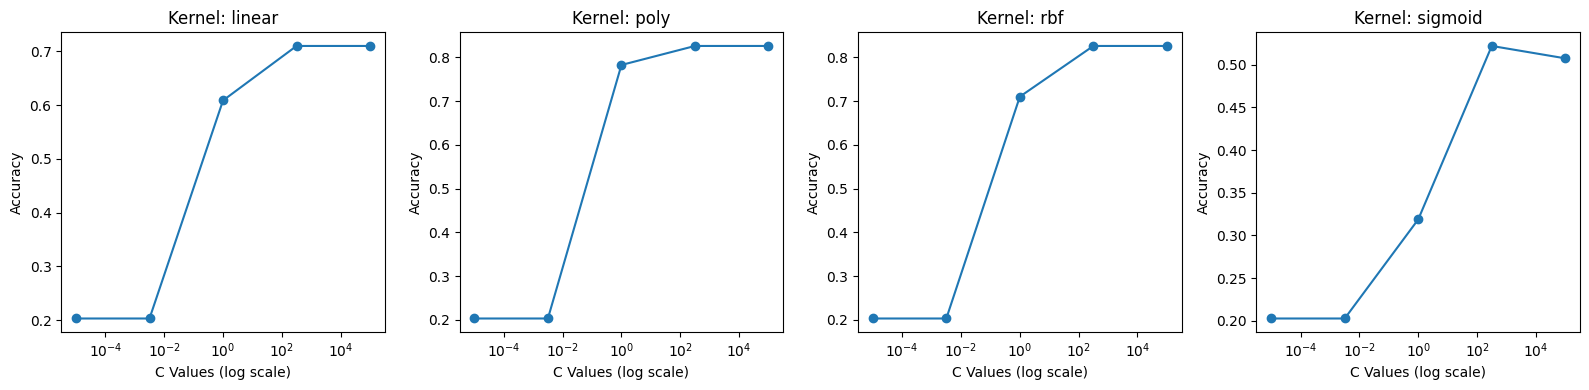

Best SVM model on validation data: C=316.22776601683796, kernel-poly | Accuracy = 0.8260869565217391
Accuracy on train data: 1.0
Accuracy on val data: 0.8260869565217391
Accuracy on test data: 0.6461538461538462


In [19]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = np.logspace(-5, 5, 5)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in tqdm(enumerate(kernels)):
    accuracy_values = []
    for C in C_values:
        svm_classifier = svm.SVC(kernel=kernel, C=C, decision_function_shape='ovr')
        svm_classifier.fit(Xtrff, Ytrf)
        accuracy = svm_classifier.score(Xvaff, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(C_values, accuracy_values, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel('C Values (log scale)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: C={best_model.C}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrff, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvaff, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xteff, Ytef)}")

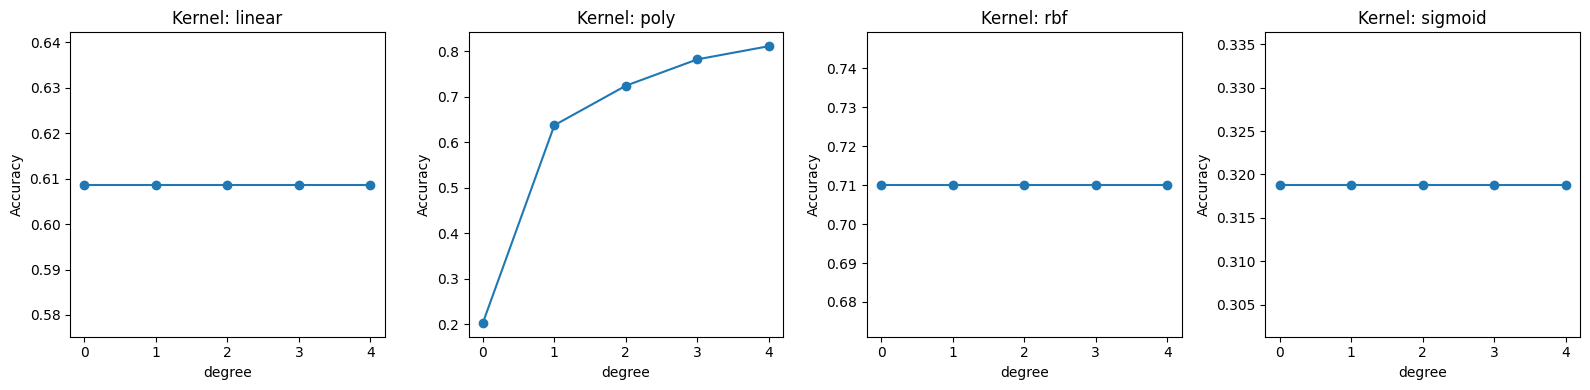

Best SVM model on validation data: d=4, kernel-poly | Accuracy = 0.8115942028985508
Accuracy on train data: 1.0
Accuracy on val data: 0.8115942028985508
Accuracy on test data: 0.6461538461538462


In [20]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = np.arange(5)
best_model = None
best_score = 0

fig, axes = plt.subplots(1, len(kernels), figsize=(16, 4))

for i, kernel in enumerate(kernels):
    accuracy_values = []
    for d in degrees:
        svm_classifier = svm.SVC(kernel=kernel, degree=d, decision_function_shape='ovr')
        svm_classifier.fit(Xtrff, Ytrf)
        accuracy = svm_classifier.score(Xvaff, Yvaf)
        if accuracy > best_score:
            best_model = svm_classifier
            best_score = accuracy
        accuracy_values.append(accuracy)
    ax = axes[i]
    ax.plot(degrees, accuracy_values, marker='o')
    ax.set_xlabel('degree')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Kernel: {kernel}')
plt.tight_layout()
plt.show()
print(f"Best SVM model on validation data: d={best_model.degree}, kernel-{best_model.kernel} | Accuracy = {best_score}")
print(f"Accuracy on train data: {best_model.score(Xtrff, Ytrf)}")
print(f"Accuracy on val data: {best_model.score(Xvaff, Yvaf)}")
print(f"Accuracy on test data: {best_model.score(Xteff, Ytef)}")

# **SLIDING WINDOW FACE DETECTION**

In [22]:
from skimage.transform import resize

In [ ]:
svm_classifier = svm.SVC(kernel="rbf", C=1.0, decision_function_shape='ovr')
svm_classifier.fit(Xtrfh, Ytrh)

In [58]:
image = cv2.imread("/content/OIP (3).jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = resize(image, (400, 400))

In [60]:
patch_size = (128, 128)
num_patches_x = image.shape[1] // patch_size[0]
num_patches_y = image.shape[0] // patch_size[1]
patches = np.empty((num_patches_x * num_patches_y, patch_size[1], patch_size[0]))
patch_index = 0
for y in range(num_patches_y):
    for x in range(num_patches_x):
        patch = image[y * patch_size[1]:(y + 1) * patch_size[1], x * patch_size[0]:(x + 1) * patch_size[0]]
        patches[patch_index] = patch
        patch_index += 1
pacthes = (patches - patch.min()) * 255/ (patches.max() - patches.min())

In [56]:
features = compute_hog(patches)

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
1it [00:00, 119.80it/s]


In [57]:
svm_classifier.predict(features)

array([0])